# Preamble
The codeblocks below are there to important the right packages, provide some helper functions, and hardcode a number of often used values. If you find yourself needed to make adjustments to these codeblocks to make the code work, please let us know as this most likely means that something has gone wrong in our implementation.

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from tqdm import tqdm

import torch.distributions as D

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

from scipy.stats import multivariate_normal
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
def reset_seeds(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  np.random.seed(seed)

In [3]:
def plot(history, direction = 1):# Select indices of points to track
  track_indices = [0, 230, 401]

  fig, ax = plt.subplots()

  # Initialize tracking lines with empty data
  tracking_lines = [ax.plot([], [], 'k-', linewidth=1, alpha=0.5)[0] for _ in track_indices]
  point_scatters = [ax.plot([], [], 'o', markersize=10)[0] for _ in track_indices]

  def init():
      ax.set_xlim(-3, 3)
      ax.set_ylim(-3, 3)
      return tracking_lines + point_scatters

  def update(tmp):
      t = int(tmp*(T/100))
      if direction < 0:
          t = T - 1 - t

      ax.clear()  # Clear the axes to remove past points
      ax.set_xlim(-3, 3)
      ax.set_ylim(-3, 3)

      # Plot all current points with a subtle color for background
      s = torch.randint(n_data, (500,))
      ax.scatter(history[t, s, 0].numpy(), history[t, s, 1].numpy(), s=10, alpha=0.6, color='#0a0a0a')

      # Color scheme for the tracked points and lines
      colors = ['#d62728', '#2ca02c', '#1f77b4']  # Red, Green, Blue

      # Update tracking lines and current positions for tracked points
      if direction > 0:
        for i, (line, scatter, index) in enumerate(zip(tracking_lines, point_scatters, track_indices)):
            if direction < 0:
                xdata = history[T-t-1:T, index, 0]
                ydata = history[T-t-1:T, index, 1]
            else:
                xdata = history[:t+1, index, 0].numpy()
                ydata = history[:t+1, index, 1].numpy()

            # Redraw tracking line with specified color and bring it to the front (zorder)
            ax.plot(xdata, ydata, '-', linewidth=2, alpha=0.8, color=colors[i], zorder=2)

            # Update and redraw current position with a matching color and larger size
            ax.plot(xdata[-1:], ydata[-1:], 'o', markersize=12, color=colors[i], zorder=3)

      # Reapply labels, titles, or custom settings here since ax.clear() removes them
      ax.set_xlabel('Dimension 1')
      ax.set_ylabel('Dimension 2')
      ax.set_title('Diffusion Process Over Time')
      ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Add grid for better readability
      ax.set_facecolor('#f0f0f0')  # Light grey background for the plot area

      return tracking_lines + point_scatters

  ani = FuncAnimation(fig, update, frames=range(int(T/(T/100))), init_func=init, blit=False)

  return HTML(ani.to_jshtml())

# Administrative Information
Again, please note that none of the tasks set are supposed to be extremely challenging and if you do run into any problems, chances are high that this is due to unclarity on our side. As such, if you are stuck on a task for a longer time, do please reach out to lars@aims.ac.za

The notebooks are roughly structured as follows:
- Coding tasks and questions are mixed together and are highlighted by the keyword: "**Task**".
- Depending on what the task is acking for, the task will be followed by either a codeblock containing some pre-writen helper code and a `#Todo` flag after which you can add your implementation, or a markdown block containing the keyword "*Answer:*" for you to provide your answer.
- Some tasks are followed by a "**Hint:**" which will contain some extra instructions for the coding implementations, or it might point you towards the right answer to a question.
- At the end of each notebook we will have a short section with additional challenging extensions that you could choose to work on if you found a topic interesting. Please note that you are not required to do these extensions. Solving one or more of the extensions does **not** by definition result in a higher grade for the course.

Lastly, to help us in improving the coding assignments in the following weeks, please fill in the anonymous feedback [form](https://forms.gle/vVBXm7nhW94yMkHr8) (you can do this for every assigment, just make sure to pick the correct day you just finished in the shee). We highly appreciate your feedback, positive and negative!

# Denoising Diffusion Probabilistic Models
In this notebook we will be implementing a Denoising Diffusion Probabilistic Model, or DDPM in short. One specific component that we will be looking at is the notion of a "noise scheduler". The choice we make for this scheduler can have a large impact on the accuracy of the samples we generate.

Before we start coding the DDPM we first generate the dataset. This is almost the exact same dataset as we used for the last two days. The only difference is that we now normalise the data to have 0 mean unit variance. The reason for this will be come clear later.

In [4]:
reset_seeds()

# Parameters for the GMM components
n_data = 500  # Total number of data points
n_gaussians = 10  # Number of GMM mixture components

# Generate parameters for GMM components
means = torch.rand(n_gaussians, 2) * 10 - 5  # Uniformly distributed in [-5, 5]
stds = torch.rand(n_gaussians, 2) * 1 + 0.5  # Uniformly distributed in [0.5, 1.5]

mixture_weights = torch.ones(n_gaussians) / n_gaussians  # Equal weights for simplicity
mixture_distribution = torch.distributions.Categorical(mixture_weights)
component_distribution = torch.distributions.Independent(torch.distributions.Normal(means, stds), 1)
gmm = torch.distributions.MixtureSameFamily(mixture_distribution, component_distribution)

# Sample data from the GMM
X = gmm.sample((n_data,))


mean = X.mean(dim=0)
std = X.std(dim=0)
X = (X - mean) / std

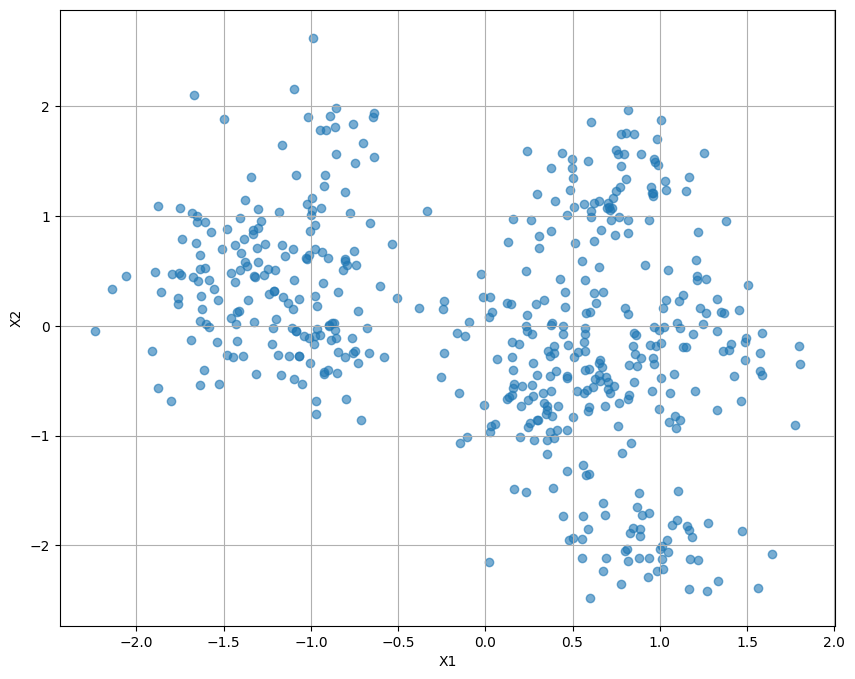

In [5]:
# Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)

plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

## Forward process: Diffusing the data
In VAE's the forward process transforming the data samples to the latent representation is performed using the Encoder network. This encoder network is a learned function.

In DDPM, or diffusion models more generally, the forward process is fixed. There are no learnable parameters here. This does however not mean that we don't have any modelling decisions to make.

As we discussed in the lecture the forward process iteratively transforms the samples by applying a transition kernel. Several choices for this transition kernel are possible, but the most used one in the DDPM literature is the Variance-Preserving (VP) kernel.
$$
x_{t+1} = \sqrt{1-\beta_t}x_t + \sqrt{\beta_t}\epsilon_t,
 \text{         with, } \epsilon_t \sim \mathcal{N}(0, I)
$$

This kernel is defined below.

(The choice to use this kernel is also why we normalized the data. It only preserves variance if we start with unit variance)

In [6]:
def q_zt_given_ztm1(z_t_minus_1, beta_t):
    return torch.sqrt(1.0 - beta_t) * z_t_minus_1 + torch.sqrt(beta_t) * torch.randn_like(z_t_minus_1)

As you can observe, the kernel is dependent on the choice of the so called "noise schedule". This schedule, defined by a series of $0 < \beta_t < 1$, can have a significant impact on the performance of the model. During the class we experimented with two different options; 1) a linear schedule, 2) a non-linear schedule based on the cosine function.

There are of course other options possible. For example, during the lecture Max always assumed $\beta$ to be fixed. This choice of schedule is what you will be experimenting with.

In [7]:
T = 1000  # Total number of timesteps
start_beta = 0.000001
end_beta = .001

betas = torch.linspace(start_beta, end_beta, T)

In [ ]:
# T = 100  # Total number of timesteps
# start_beta = 0.0001
# end_beta = .1

# betas = torch.linspace(start_beta, end_beta, T)

In [ ]:
# T = 1000
# beta_start = 1e-6
# beta_end = 2e-3
# timesteps = torch.arange(T, dtype=torch.float32) / (T - 1)
# cos_values = (torch.cos(np.pi * timesteps + np.pi) + 1) / 2
# betas = beta_start + (beta_end - beta_start) * cos_values

### Running the diffusion process
In the codeblocks below we run and visualize the diffusion process using the scheduler defined above. You can observe that after T steps the samples are roughly normally distributed.

To clarify, the colored points in the plot are nothing special. These are simply regular points colored such that we can track how they move around over time.

In [8]:
forward_history = torch.zeros(T, n_data, 2)
forward_history[0, :] = X

for t in range(1, T):
  beta_t = betas[t-1]
  forward_history[t, :] = q_zt_given_ztm1(forward_history[t-1, :], beta_t)

In [9]:
plot(forward_history, 1)

Output hidden; open in https://colab.research.google.com to view.

# Backward process - Denoising
With the implementation of the backward process we are now getting to the meat of the code. The backward process is the learnable component of a DDPM. This is done by parameterizing a neural network and training it to denoise a noisy sample.

One key component for making this learning process tractable is to assume Gaussian transitions between the samples in the forward process. While, even with this choice, it is still not easy to define the marginals at every time-step t it is possible to get the marginals conditioned on a single datasample. This is implemented below.

Please have a look at the derivations in the lecture notes to understand why we can define these conditional distributions.


In [12]:
def q_zt_given_zt0(X, t, betas):
    # Compute the alphas and their cumulative product
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # Gather the cumulative product of alphas corresponding to each timestep t for each sample
    alphas_cumprod_t = alphas_cumprod[t]
    alphas_cumprod_t = alphas_cumprod_t.view(-1, 1)

    # Compute the noise
    epsilon = torch.randn_like(X)

    # Compute the noised data z_t for the given timesteps t
    z_t = torch.sqrt(alphas_cumprod_t) * X + torch.sqrt(1.0 - alphas_cumprod_t) * epsilon

    return z_t, epsilon

The next component that we are implementing is the Noise Prediction Network (NPN). The NPN takes as an input a noisy sample at a time-step t (it's important to also pass the time t into the model), and tries to predict the noise that was added to this sample.

In [13]:
class NoisePredictionNetwork(nn.Module):
    def __init__(self, input_dim=2, output_dim=2, hidden_dims=[64, 64], time_embedding_dim=16):
        super(NoisePredictionNetwork, self).__init__()
        self.time_embedding = nn.Linear(1, time_embedding_dim)  # Embedding layer for the timestep

        # Adjust input dimension to account for time embedding
        adjusted_input_dim = input_dim + time_embedding_dim

        self.layers = nn.ModuleList()
        last_dim = adjusted_input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(last_dim, hidden_dim))
            last_dim = hidden_dim
        self.final_layer = nn.Linear(last_dim, output_dim)


    def forward(self, x, t):
        # Embed the timestep
        t_embedded = F.relu(self.time_embedding(t.unsqueeze(-1)))

        # Concatenate the embedded timestep with the original input
        x = torch.cat([x, t_embedded], dim=1)
        for layer in self.layers:
            x = F.relu(layer(x))

        x = self.final_layer(x)
        return x

In [14]:
model = NoisePredictionNetwork(hidden_dims=[64, 128, 64])

Lastly we have the training loop. As we derived during the lecture, the loss funtion of a DDPM can be implemented as a MSE loss between the predicted noise and the actuall noise.

In [15]:
from torch.nn.utils import clip_grad_norm_

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
loss_function = nn.MSELoss()

# Training loop
epochs = 1000
for epoch in tqdm(range(epochs)):
    t = torch.randint(0, T, (X.size(0),), device=X.device)

    z_t, noise = q_zt_given_zt0(X, t, betas)

    # Predict the noise using the model
    t = t.float() / (T - 1)
    model_output = model(z_t, t)

    loss = F.mse_loss(model_output, noise)

    clip_grad_norm_(model.parameters(), max_norm=0.5)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    if epoch % 100 == 0:
        print(f'[{epoch}]\tLoss: {loss.item():.6f}')

  2%|▏         | 19/1000 [00:00<00:09, 99.94it/s]

[0]	Loss: 1.065932


 12%|█▏        | 120/1000 [00:00<00:06, 144.46it/s]

[100]	Loss: 0.851465


 22%|██▏       | 223/1000 [00:01<00:05, 137.80it/s]

[200]	Loss: 0.768558


 32%|███▏      | 322/1000 [00:02<00:05, 130.96it/s]

[300]	Loss: 0.717734


 42%|████▏     | 424/1000 [00:03<00:03, 172.26it/s]

[400]	Loss: 0.756281


 51%|█████▏    | 513/1000 [00:03<00:04, 102.27it/s]

[500]	Loss: 0.717537


 64%|██████▍   | 643/1000 [00:04<00:01, 187.91it/s]

[600]	Loss: 0.813209


 73%|███████▎  | 726/1000 [00:05<00:01, 198.21it/s]

[700]	Loss: 0.755054


 83%|████████▎ | 827/1000 [00:05<00:00, 196.41it/s]

[800]	Loss: 0.760419


 93%|█████████▎| 933/1000 [00:06<00:00, 206.63it/s]

[900]	Loss: 0.795663


100%|██████████| 1000/1000 [00:06<00:00, 153.14it/s]


## Sampling from a DDPM
In the block below we have implemented the sampling procedure of the DDPM. The sampling procedure starts by sampling a random sample from the Normal distribution with zero mean and unit variance. Following this, we use the trained NPN to denoise the sample step by step. As you can see, we need to apply the t's in reverse order for this (from t=T to t=0).

In [16]:
def sample(starting_point, temp = 1.):
    # Precompute alphas and their cumulative product
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    # Initialize the history of z's with the last one being from the prior
    history = torch.zeros(T, starting_point.shape[0], 2)
    history[-1] = starting_point

    # Reverse diffusion process to denoise the samples
    for t in reversed(range(T - 1)):
        # Extract the relevant alphas and betas for the current timestep
        alpha_t = alphas[t]
        alpha_cumprod_t = alphas_cumprod[t]
        alpha_cumprod_prev_t = alphas_cumprod_prev[t]

        # Calculate the mean of q(z_{t-1} | z_t, z_0)
        # Using the model to predict epsilon_t
        with torch.no_grad():
            ts = torch.full((starting_point.shape[0],), t, dtype=torch.float32) / (T - 1)
            epsilon_t = model(history[t + 1], ts)
        mean = (history[t + 1] - torch.sqrt(1.0 - alpha_cumprod_t) * epsilon_t) / torch.sqrt(alpha_cumprod_prev_t)

        # Sample z_{t-1}
        if t == 0:
            # No need to add noise when t == 0 as we've reached the end of the reverse process
            history[t] = mean
        else:
            history[t] = mean + torch.sqrt(betas[t]) * torch.randn(starting_point.shape[0], 2) * temp

    # z_history now contains the denoised samples over time

    return history

However, unfortunately, DDPMs often suffer from mode collapse where the denoising process quickly collapses in a small number of modes. This can be seen happening in the plot below.

In [17]:
z_from_prior = torch.randn(500, 2)
reverse_history = sample(z_from_prior)

plot(reverse_history, -1)

Output hidden; open in https://colab.research.google.com to view.

Fortunately, researchers have found a trick to overcome this problem by introducing a temperature parameter into the sampling process. We have already implemented this and can active it by passing a desired temperature to the sample function.

It is important to note that choosing this temperature is somewhat tricky and arbitrary. You might need to try a couple of values for the temperature if you make any changes to the rest of the code.

In [ ]:
z_from_prior = torch.randn(500, 2)
reverse_history = sample(z_from_prior, temp=10.)

plot(reverse_history, -1)

# Assignment
We already discussed that there are many different options possible for the noise schedule $\beta_t$. This asignment will ask you to try different noise schedulers. We will specifically be focussing on a constant noise schedule, but feel free to experiment further.

**TASK:**
- Implement the constant noise schedule that Max used in his lecture. ie. set $\beta_t = c$ for all $t$ where $c$ is some arbitrary constant.
- Experiment with the choice of $c$. If possible, try to create a visualization for this.
- What happens if $c$ is very small? Specifically, what happens to the latent representation?
- Did you need to change the temperature for the sampling procedure at all?



# Answer:
3. when the constant $c$ choose is very small ,
 it indicates that only a small amount of noise is added to the dat at each iteration. As a result, the variance of the data changes slowly over time ( remains relatively stable ). specificaly, we observe:

 * a slow increase in noise level over the diffusion process
 *  decrease of variability in the latent representation
 *  less abrupt transitions between different states in the latent space.

 in conclusion, we observe smoother latent representation and reduced noise.

4. No, I did not need to change the temperature for the sampling procedure.

In [45]:
#@title Forward process of the diffusion model { run: "auto"}
T = 1000  # Total number of timesteps

## change the tensor beta to a constant tensor ( interactif slide to choose the constant)

beta=0.00082 #@param {type:"slider", min:0, max:1, step:0.00001}

### beta value at each time ( constant )
betas = torch.full((T,), beta)

#### delete the previous model
del model


In [46]:
#@title runing the diffusion process
forward_history = torch.zeros(T, n_data, 2)
forward_history[0, :] = X

for t in range(1, T):
  beta_t = betas[t-1]
  forward_history[t, :] = q_zt_given_ztm1(forward_history[t-1, :], beta_t)

plot(forward_history, 1)

Output hidden; open in https://colab.research.google.com to view.

In [47]:
#@title Backward process-Denoising

def q_zt_given_zt0(X, t, betas):
    # Compute the alphas and their cumulative product
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # Gather the cumulative product of alphas corresponding to each timestep t for each sample
    alphas_cumprod_t = alphas_cumprod[t]
    alphas_cumprod_t = alphas_cumprod_t.view(-1, 1)

    # Compute the noise
    epsilon = torch.randn_like(X)

    # Compute the noised data z_t for the given timesteps t
    z_t = torch.sqrt(alphas_cumprod_t) * X + torch.sqrt(1.0 - alphas_cumprod_t) * epsilon

    return z_t, epsilon

########################

class NoisePredictionNetwork(nn.Module):
    def __init__(self, input_dim=2, output_dim=2, hidden_dims=[64, 64], time_embedding_dim=16):
        super(NoisePredictionNetwork, self).__init__()
        self.time_embedding = nn.Linear(1, time_embedding_dim)  # Embedding layer for the timestep

        # Adjust input dimension to account for time embedding
        adjusted_input_dim = input_dim + time_embedding_dim

        self.layers = nn.ModuleList()
        last_dim = adjusted_input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(last_dim, hidden_dim))
            last_dim = hidden_dim
        self.final_layer = nn.Linear(last_dim, output_dim)


    def forward(self, x, t):
        # Embed the timestep
        t_embedded = F.relu(self.time_embedding(t.unsqueeze(-1)))

        # Concatenate the embedded timestep with the original input
        x = torch.cat([x, t_embedded], dim=1)
        for layer in self.layers:
            x = F.relu(layer(x))

        x = self.final_layer(x)
        return x

############# Model

model = NoisePredictionNetwork(hidden_dims=[64, 128, 64])

#################

from torch.nn.utils import clip_grad_norm_

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
loss_function = nn.MSELoss()

# Training loop
epochs = 1000
for epoch in tqdm(range(epochs)):
    t = torch.randint(0, T, (X.size(0),), device=X.device)

    z_t, noise = q_zt_given_zt0(X, t, betas)

    # Predict the noise using the model
    t = t.float() / (T - 1)
    model_output = model(z_t, t)

    loss = F.mse_loss(model_output, noise)

    clip_grad_norm_(model.parameters(), max_norm=0.5)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    if epoch % 100 == 0:
        print(f'[{epoch}]\tLoss: {loss.item():.6f}')


  1%|▏         | 14/1000 [00:00<00:07, 134.15it/s]

[0]	Loss: 0.989033


 13%|█▎        | 127/1000 [00:00<00:05, 149.49it/s]

[100]	Loss: 0.674133


 23%|██▎       | 233/1000 [00:01<00:05, 144.20it/s]

[200]	Loss: 0.618630


 34%|███▍      | 340/1000 [00:02<00:03, 180.59it/s]

[300]	Loss: 0.599330


 43%|████▎     | 432/1000 [00:02<00:02, 214.47it/s]

[400]	Loss: 0.627050


 54%|█████▍    | 543/1000 [00:03<00:02, 213.87it/s]

[500]	Loss: 0.595658


 64%|██████▎   | 635/1000 [00:03<00:01, 224.03it/s]

[600]	Loss: 0.622716


 73%|███████▎  | 728/1000 [00:04<00:01, 228.38it/s]

[700]	Loss: 0.644250


 85%|████████▍ | 846/1000 [00:04<00:00, 231.08it/s]

[800]	Loss: 0.572343


 94%|█████████▍| 940/1000 [00:04<00:00, 225.75it/s]

[900]	Loss: 0.624843


100%|██████████| 1000/1000 [00:05<00:00, 191.45it/s]


In [48]:
#@title Sampling from a DDPM

def sample(starting_point, temp = 1):
    # Precompute alphas and their cumulative product
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    # Initialize the history of z's with the last one being from the prior
    history = torch.zeros(T, starting_point.shape[0], 2)
    history[-1] = starting_point

    # Reverse diffusion process to denoise the samples
    for t in reversed(range(T - 1)):
        # Extract the relevant alphas and betas for the current timestep
        alpha_t = alphas[t]
        alpha_cumprod_t = alphas_cumprod[t]
        alpha_cumprod_prev_t = alphas_cumprod_prev[t]

        # Calculate the mean of q(z_{t-1} | z_t, z_0)
        # Using the model to predict epsilon_t
        with torch.no_grad():
            ts = torch.full((starting_point.shape[0],), t, dtype=torch.float32) / (T - 1)
            epsilon_t = model(history[t + 1], ts)
        mean = (history[t + 1] - torch.sqrt(1.0 - alpha_cumprod_t) * epsilon_t) / torch.sqrt(alpha_cumprod_prev_t)

        # Sample z_{t-1}
        if t == 0:
            # No need to add noise when t == 0 as we've reached the end of the reverse process
            history[t] = mean
        else:
            history[t] = mean + torch.sqrt(betas[t]) * torch.randn(starting_point.shape[0], 2) * temp

    # z_history now contains the denoised samples over time

    return history

###### plot

z_from_prior = torch.randn(500, 2)
reverse_history = sample(z_from_prior,temp=3)

plot(reverse_history, -1)

Output hidden; open in https://colab.research.google.com to view.